In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV
from scipy.stats import uniform, randint

In [184]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [185]:
seasons_df=pd.read_pickle('data/seasons_df.pkl')

In [186]:
seasons_df['Date'].is_monotonic_increasing

True

Going to one hot encode the 2 team names. So I can see if the relationship status between the two teams is important

In [190]:
seasons_df=pd.get_dummies(seasons_df, columns=['HomeTeam', 'AwayTeam'])

In [191]:
seasons_df

,Date,FTR,home.matchNumber,away.matchNumber,season,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves
0,2009-08-15,A,1,1,season09,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,2009-08-15,A,1,1,season09,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2009-08-15,A,1,1,season09,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [193]:
#no nulls once all teams have played 4 games
#seasons_df[(seasons_df['home.matchNumber']>=4) & (seasons_df['away.matchNumber']>=4)].isna().any().any()

In [194]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [196]:
seasons_df.drop(columns=['Date'], inplace=True)

In [197]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

Make the train and test sets

In [198]:
#filtering out the matches before a team has played 3 matches that season
#seasons_df=seasons_df.dropna()


In [199]:
train=seasons_df[~(seasons_df['season']=='season17')]
train=train.copy()
train.drop('season', axis=1, inplace=True)

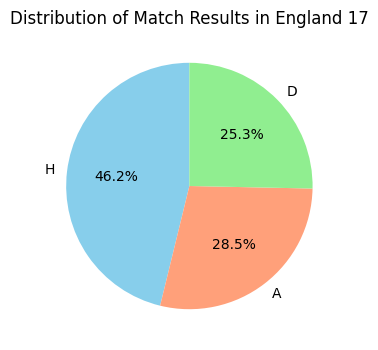

In [200]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England 17")
plt.show()


In [201]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [202]:
test=seasons_df[seasons_df['season']=='season17']
test=test.copy()
test.drop('season', axis=1, inplace=True)

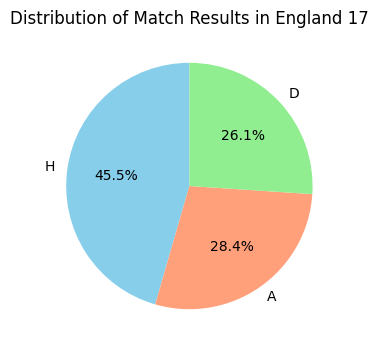

In [203]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England 17")
plt.show()


In [204]:
X_test=test.drop(['label', 'FTR'], axis=1)
y_test=test['label']

Scale the features

In [205]:
seasons_df

,FTR,home.matchNumber,away.matchNumber,season,diff.daysSince,diff.total.win,diff.total.draw,diff.total.loss,diff.total.goals,diff.total.conceded,diff.total.half_goals,diff.total.half_conceded,diff.total.shots,diff.total.shots_against,diff.total.shots_target,diff.total.shots_against_target,diff.total.corners,diff.total.corners_conceded,diff.total.fouls,diff.total.fouls_other_team,diff.total.yellows,diff.total.reds,diff.last3.win,diff.last3.draw,diff.last3.loss,diff.last3.goals,diff.last3.conceded,diff.last3.half_goals,diff.last3.half_conceded,diff.last3.shots,diff.last3.shots_against,diff.last3.shots_target,diff.last3.shots_against_target,diff.last3.corners,diff.last3.corners_conceded,diff.last3.fouls,diff.last3.fouls_other_team,diff.last3.yellows,diff.last3.reds,diff.total.win.whenHorA,diff.total.draw.whenHorA,diff.total.loss.whenHorA,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man United,HomeTeam_Middlesbrough,HomeTeam_Newcastle,HomeTeam_Norwich,HomeTeam_Portsmouth,HomeTeam_QPR,HomeTeam_Reading,HomeTeam_Southampton,HomeTeam_Stoke,HomeTeam_Sunderland,HomeTeam_Swansea,HomeTeam_Tottenham,HomeTeam_Watford,HomeTeam_West Brom,HomeTeam_West Ham,HomeTeam_Wigan,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Aston Villa,AwayTeam_Birmingham,AwayTeam_Blackburn,AwayTeam_Blackpool,AwayTeam_Bolton,AwayTeam_Bournemouth,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,label
0,A,1,1,season09,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0
1,A,1,1,season09,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0
2,A,1,1,season09,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0
3,H,1,1,season09,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [208]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [209]:
X_test

array([[-1.6871149 , -1.68699492,  0.00863649, ..., -0.21389632,
        -0.16012815, -0.1382327 ],
       [-1.6871149 , -1.68699492,  0.00863649, ..., -0.21389632,
        -0.16012815, -0.1382327 ],
       [-1.6871149 , -1.68699492,  0.00863649, ..., -0.21389632,
        -0.16012815, -0.1382327 ],
       ...,
       [ 1.68639509,  1.68771498, -1.47749117, ..., -0.21389632,
        -0.16012815, -0.1382327 ],
       [ 1.68639509,  1.68771498,  0.00863649, ..., -0.21389632,
        -0.16012815, -0.1382327 ],
       [ 1.68639509,  1.68771498, -2.46824294, ..., -0.21389632,
        -0.16012815, -0.1382327 ]])

### RandomForest

In [210]:
# Step 4: Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [211]:
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.52


In [212]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate the model's performance using accuracy and a classification report.
    
    Parameters:
    model: The trained model
    X_test: Test features
    y_test: Actual labels for the test set
    label_encoder: The label encoder used to transform labels
    
    Returns:
    None
    """
    # Step 1: Make predictions
    y_pred = model.predict(X_test)
    
    # Step 2: Convert predicted numeric labels back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    # Step 3: Convert actual labels back to original labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    
    # Step 4: Calculate and print accuracy
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Model accuracy: {accuracy:.2f}")
    
    # Step 5: Generate and print classification report
    class_report = classification_report(y_test_labels, y_pred_labels)
    print("\nClassification Report:")
    print(class_report)



In [213]:

evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.52

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.56      0.53       108
           D       0.24      0.05      0.08        99
           H       0.56      0.76      0.64       173

    accuracy                           0.52       380
   macro avg       0.43      0.46      0.42       380
weighted avg       0.46      0.52      0.47       380



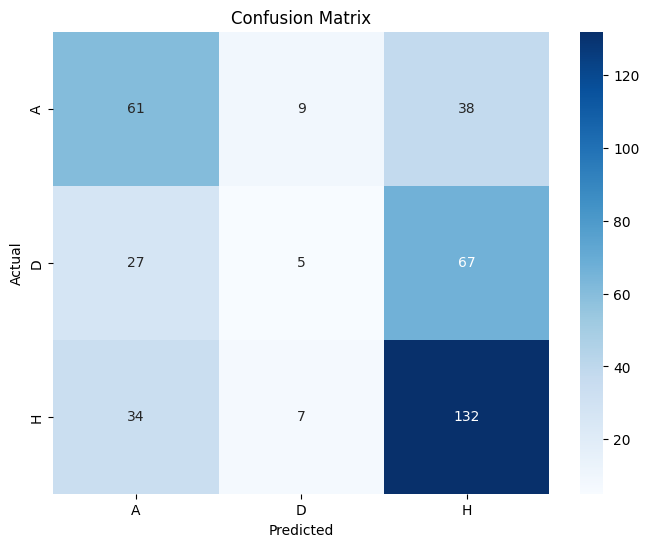

In [214]:
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [215]:

# Get feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame to make it easier to read
feature_importance_df = pd.DataFrame({
    'Feature': train.drop(['label','FTR'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

## Plot the feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
#plt.show()

                        Feature  Importance
12      diff.total.shots_target    0.037974
10             diff.total.shots    0.034900
11     diff.total.shots_against    0.033855
6              diff.total.goals    0.031560
15  diff.total.corners_conceded    0.030210
..                          ...         ...
99          AwayTeam_Portsmouth    0.000171
54        HomeTeam_Huddersfield    0.000000
83            AwayTeam_Brighton    0.000000
90        AwayTeam_Huddersfield    0.000000
47            HomeTeam_Brighton    0.000000

[112 rows x 2 columns]


In [216]:
%%time
#Wall time: 1min 37s

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_iter=10, verbose=1)
random_search.fit(X_train, y_train)
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}
CPU times: user 1min 36s, sys: 286 ms, total: 1min 37s
Wall time: 1min 37s


In [217]:
# Step 5: Evaluate the model
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.54


In [218]:

evaluate_model(random_search, X_test, y_test, label_encoder)

Model accuracy: 0.54

Classification Report:
              precision    recall  f1-score   support

           A       0.54      0.58      0.56       108
           D       0.43      0.03      0.06        99
           H       0.55      0.82      0.66       173

    accuracy                           0.54       380
   macro avg       0.51      0.48      0.42       380
weighted avg       0.52      0.54      0.47       380



## XGBoost

In [219]:
# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [220]:
# Predict and evaluate
y_pred = model.predict(X_test)


In [221]:

evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.49

Classification Report:
              precision    recall  f1-score   support

           A       0.48      0.51      0.49       108
           D       0.31      0.16      0.21        99
           H       0.55      0.68      0.61       173

    accuracy                           0.49       380
   macro avg       0.45      0.45      0.44       380
weighted avg       0.47      0.49      0.47       380



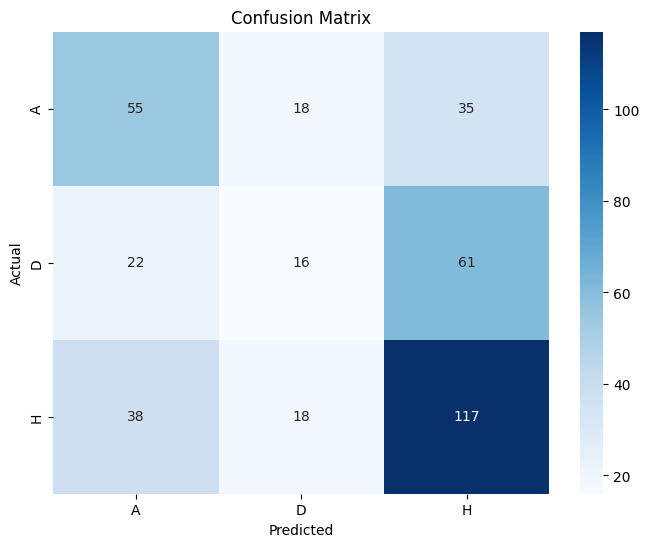

In [222]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [223]:
%%time
#Wall time: 1min 37s

# Define the model
model = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),          # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),         # Learning rate
    'max_depth': randint(3, 10),                 # Max depth of tree
    'min_child_weight': randint(1, 10),          # Min child weight
    'subsample': uniform(0, 1),              # Fraction of samples used for each tree
    'colsample_bytree': uniform(0, 1),       # Fraction of features for each tree
    'gamma': uniform(0, 1),                      # Gamma (min loss reduction)
    'reg_alpha': uniform(0, 1),                  # L1 regularization term
    'reg_lambda': uniform(0, 1),                 # L2 regularization term
}

# Define the recall scorer for multiclass classification
#f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize RandomizedSearchCV with the updated scorer
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=10, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters
print(f'Best Parameters: {random_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'colsample_bytree': 0.6075448519014384, 'gamma': 0.17052412368729153, 'learning_rate': 0.029515477895583855, 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 415, 'reg_alpha': 0.5632882178455393, 'reg_lambda': 0.3854165025399161, 'subsample': 0.015966252220214194}
CPU times: user 8.09 s, sys: 881 ms, total: 8.97 s
Wall time: 58.2 s


In [224]:
y_pred = random_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Model accuracy: 0.51


In [225]:
evaluate_model(random_search, X_test, y_test, label_encoder)

Model accuracy: 0.51

Classification Report:
              precision    recall  f1-score   support

           A       0.47      0.65      0.55       108
           D       0.25      0.01      0.02        99
           H       0.54      0.72      0.62       173

    accuracy                           0.51       380
   macro avg       0.42      0.46      0.39       380
weighted avg       0.45      0.51      0.44       380



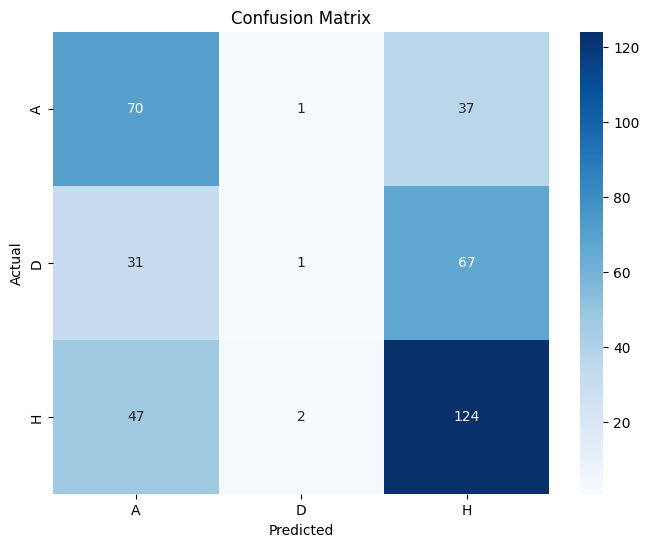

In [226]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [249]:
# Best hyperparameters from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.10,
    'gamma': 0.19,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 500,
    'reg_alpha': 0.37,
    'reg_lambda': 0.79,
    'subsample': 0.60
}

model = xgb.XGBClassifier(**best_params)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.19, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [250]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [251]:
evaluate_model(model, X_test, y_test, label_encoder)

Model accuracy: 0.54

Classification Report:
              precision    recall  f1-score   support

           A       0.50      0.56      0.53       108
           D       0.43      0.03      0.06        99
           H       0.56      0.81      0.66       173

    accuracy                           0.54       380
   macro avg       0.50      0.47      0.42       380
weighted avg       0.51      0.54      0.47       380



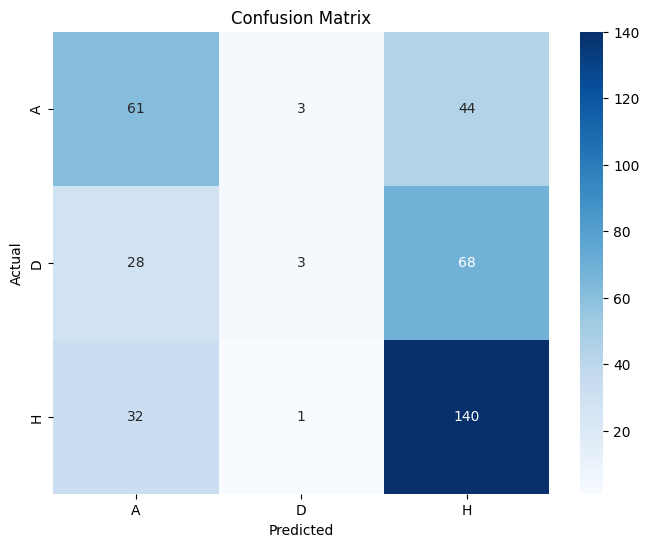

In [252]:
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [262]:
# Get feature importance from the model
feature_importances = model.feature_importances_

# Create a DataFrame to make it easier to read
feature_importance_df = pd.DataFrame({
    'Feature': train.drop(['label','FTR'], axis=1).columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
feature_importance_df.head(50)

## Plot the feature importance
#plt.figure(figsize=(10, 6))
#plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
#plt.show()

,Feature,Importance
12,diff.total.shots_target,0.020437
10,diff.total.shots,0.018202
14,diff.total.corners,0.015654
95,AwayTeam_Man United,0.015264
6,diff.total.goals,0.014840
59,HomeTeam_Man United,0.014583
11,diff.total.shots_against,0.014323
3,diff.total.win,0.014237
15,diff.total.corners_conceded,0.013823
94,AwayTeam_Man City,0.013749
